Dataset cargado correctamente: Exportaciones_limpias.csv

=== EXPLORACIÓN INICIAL DE LOS DATOS ===
Dimensiones del dataset: (475785, 11)

Primeras filas del dataset:
     Partida                   Descripcion Partida10 Dig Tradición productos  \
0  101210000  Caballos reproductores de raza pura, vivos      No tradicional   
1  101210000  Caballos reproductores de raza pura, vivos      No tradicional   
2  101210000  Caballos reproductores de raza pura, vivos      No tradicional   
3  101210000  Caballos reproductores de raza pura, vivos      No tradicional   
4  101210000  Caballos reproductores de raza pura, vivos      No tradicional   

  Departamento   Pais   Año  Mes  Exportaciones en valor (Miles USD FOB)  \
0    Antioquia  China  2019    4                                       0   
1    Antioquia  China  2020    2                                       0   
2    Antioquia  China  2022    1                                       0   
3    Antioquia  China  2022    4                 

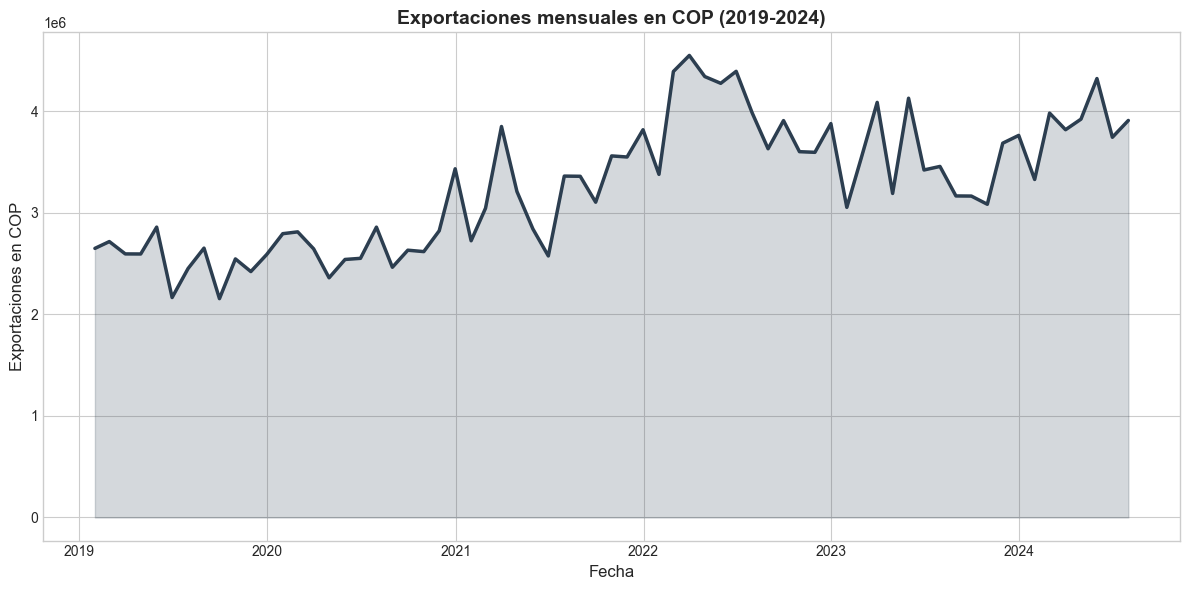

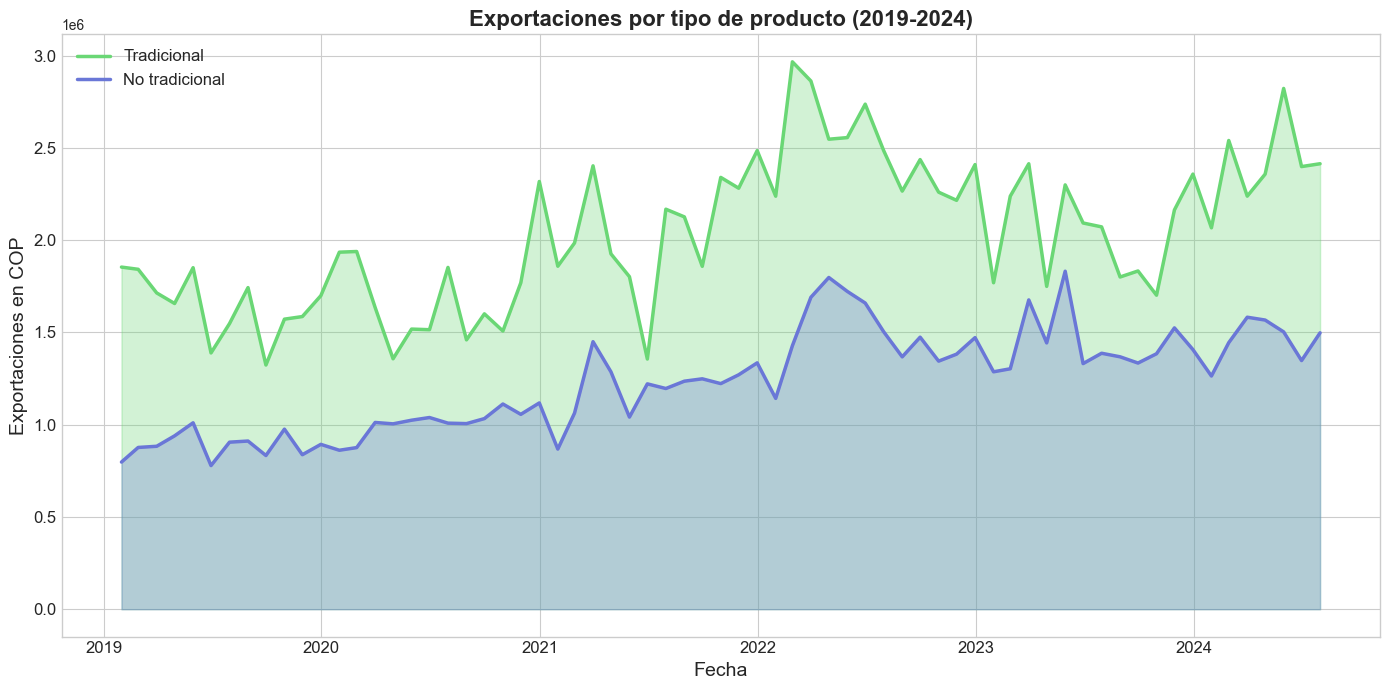

<Figure size 1200x700 with 0 Axes>

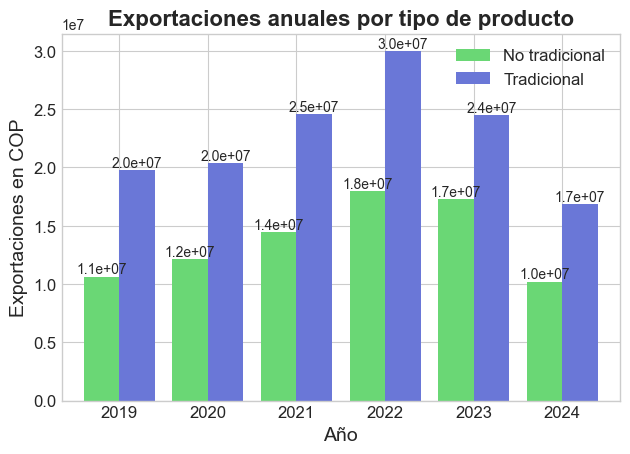

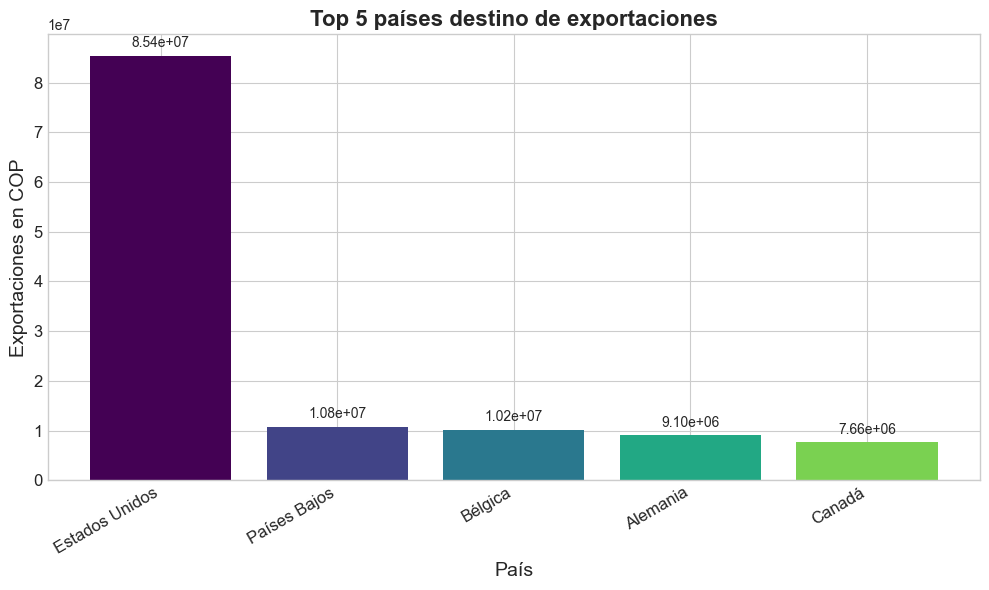

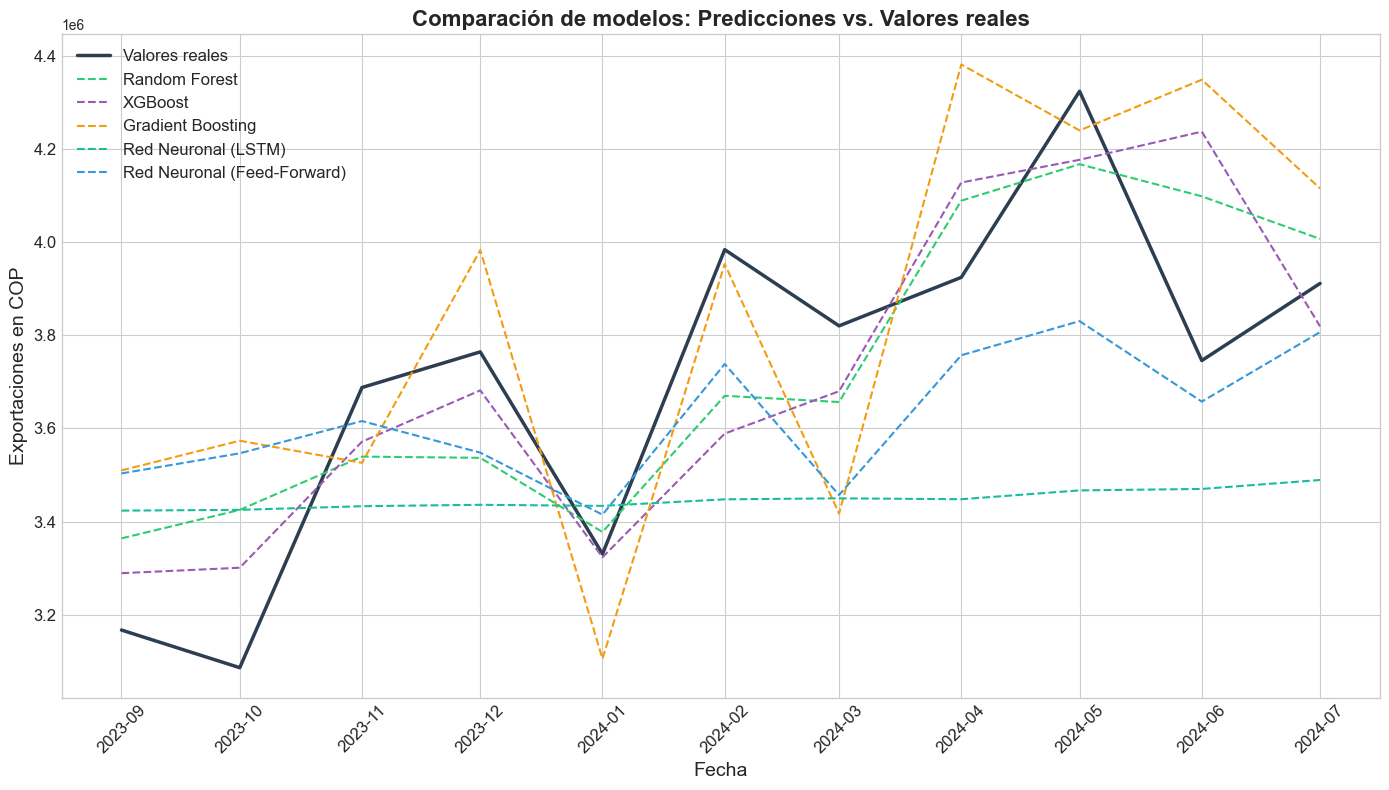

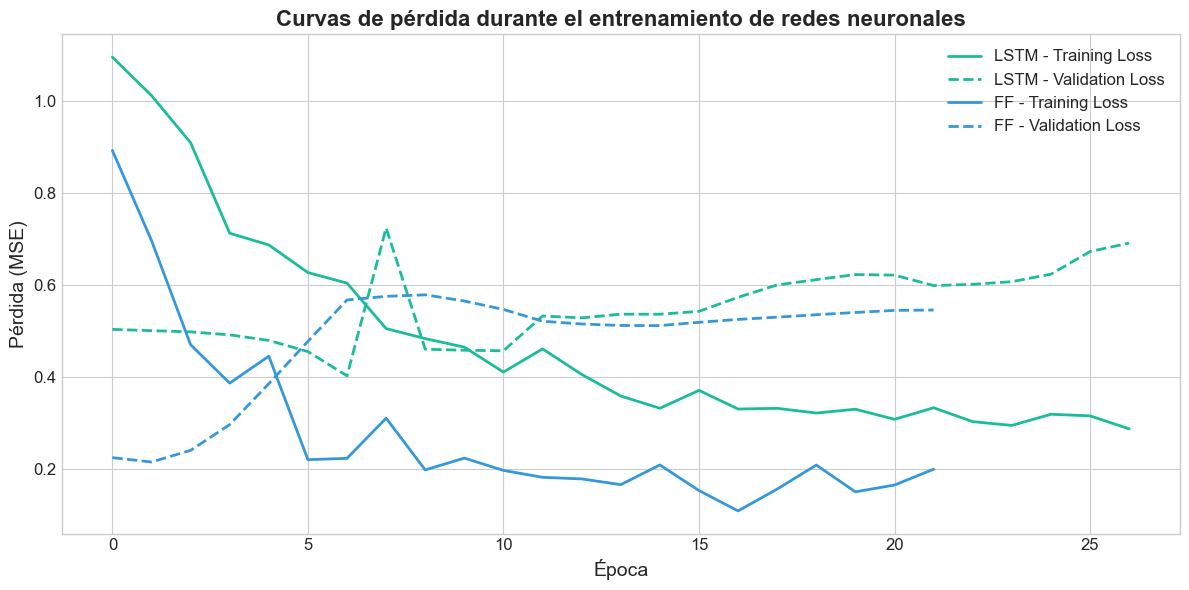

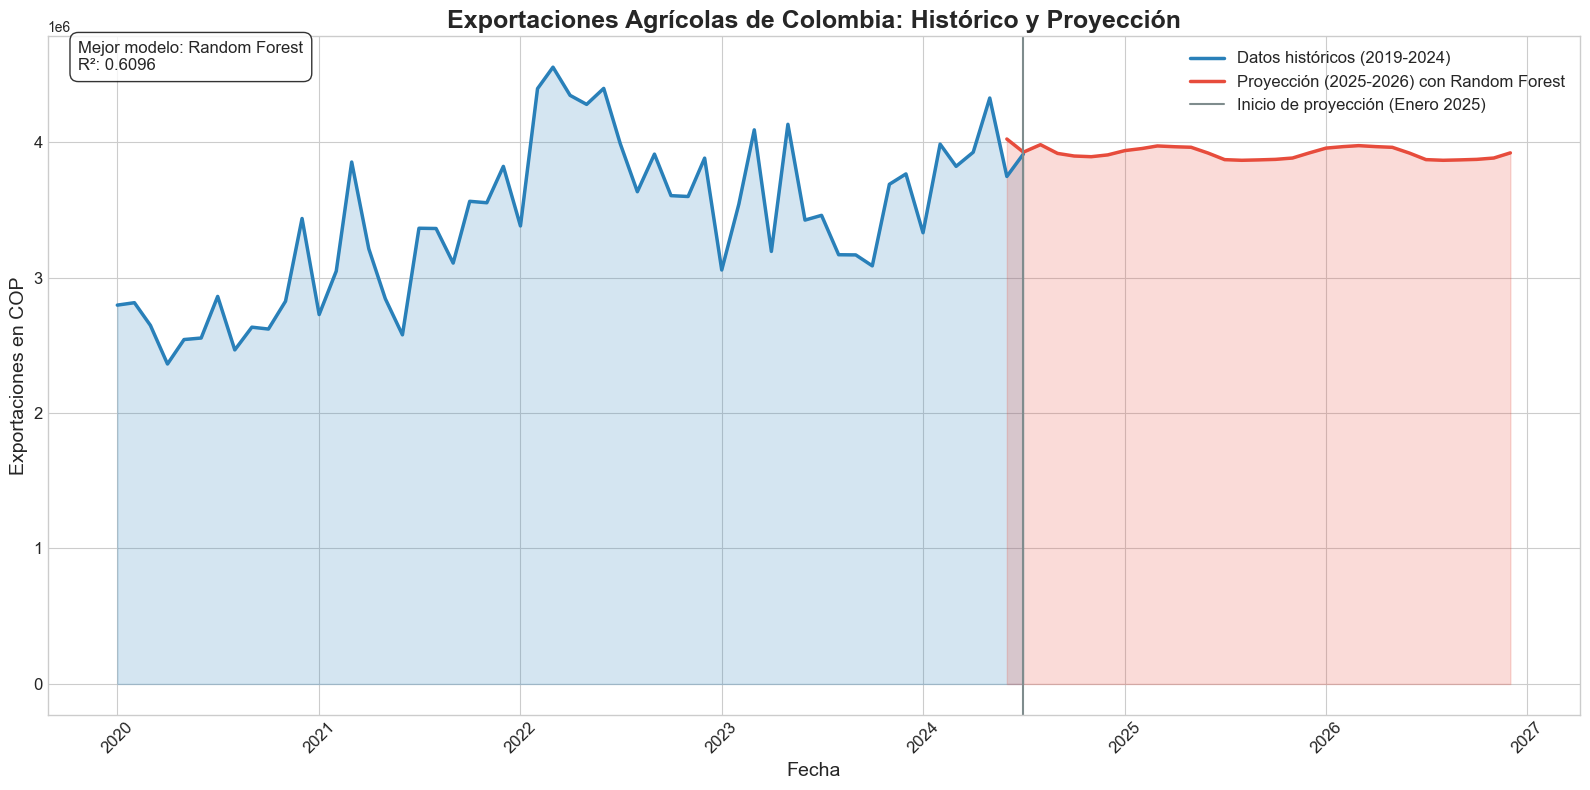

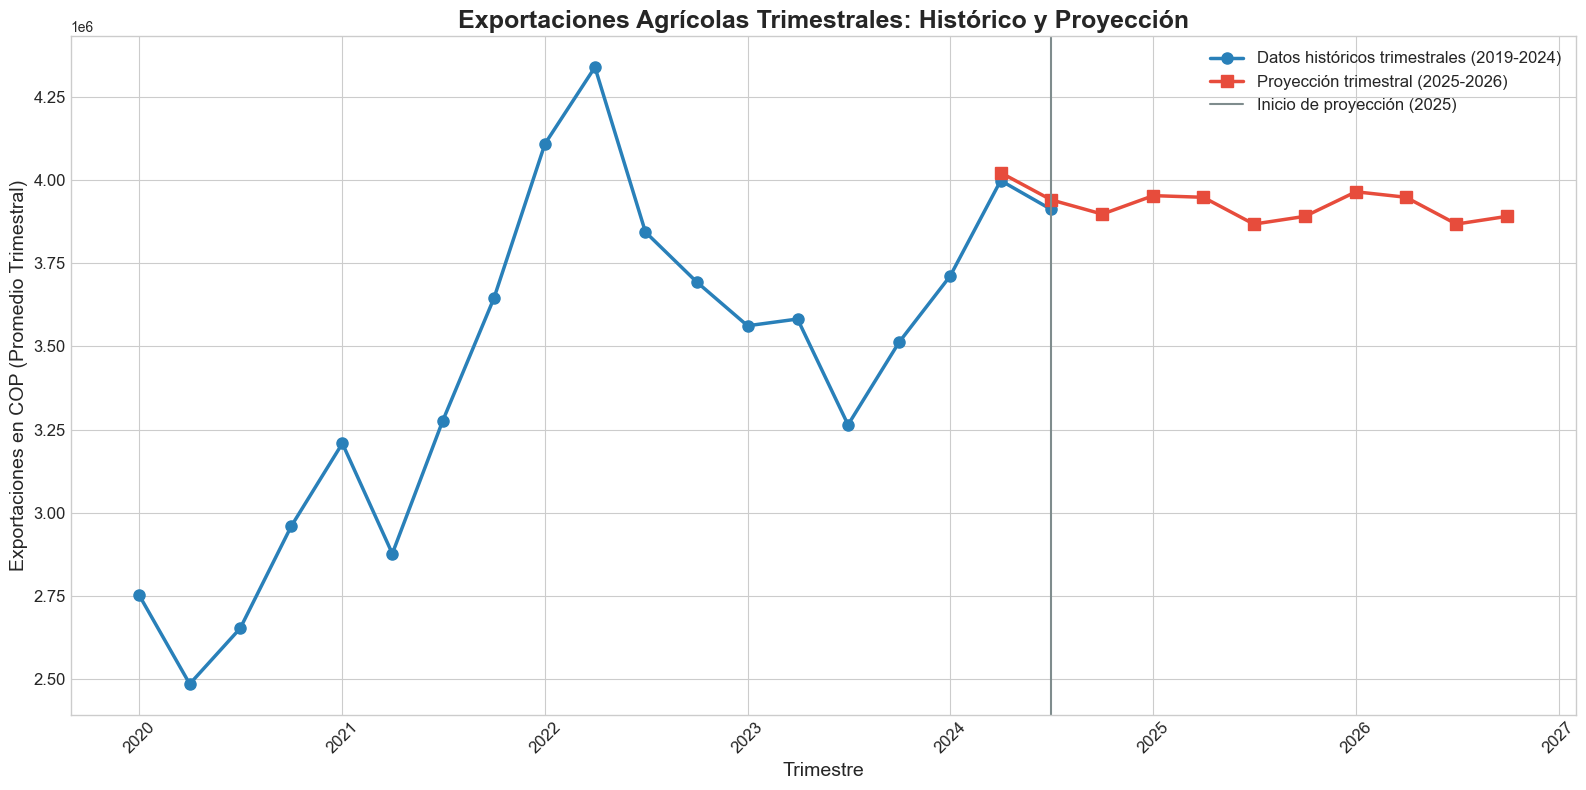

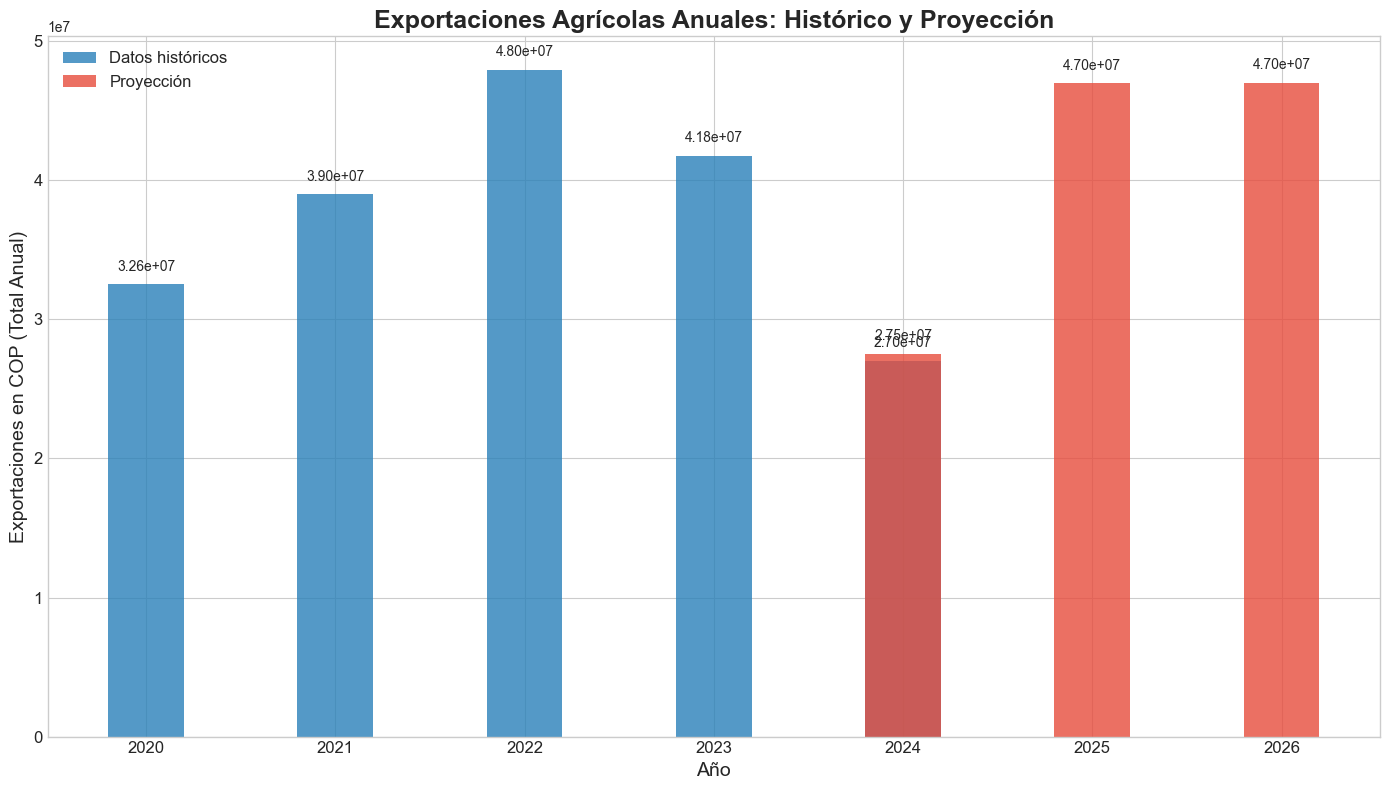

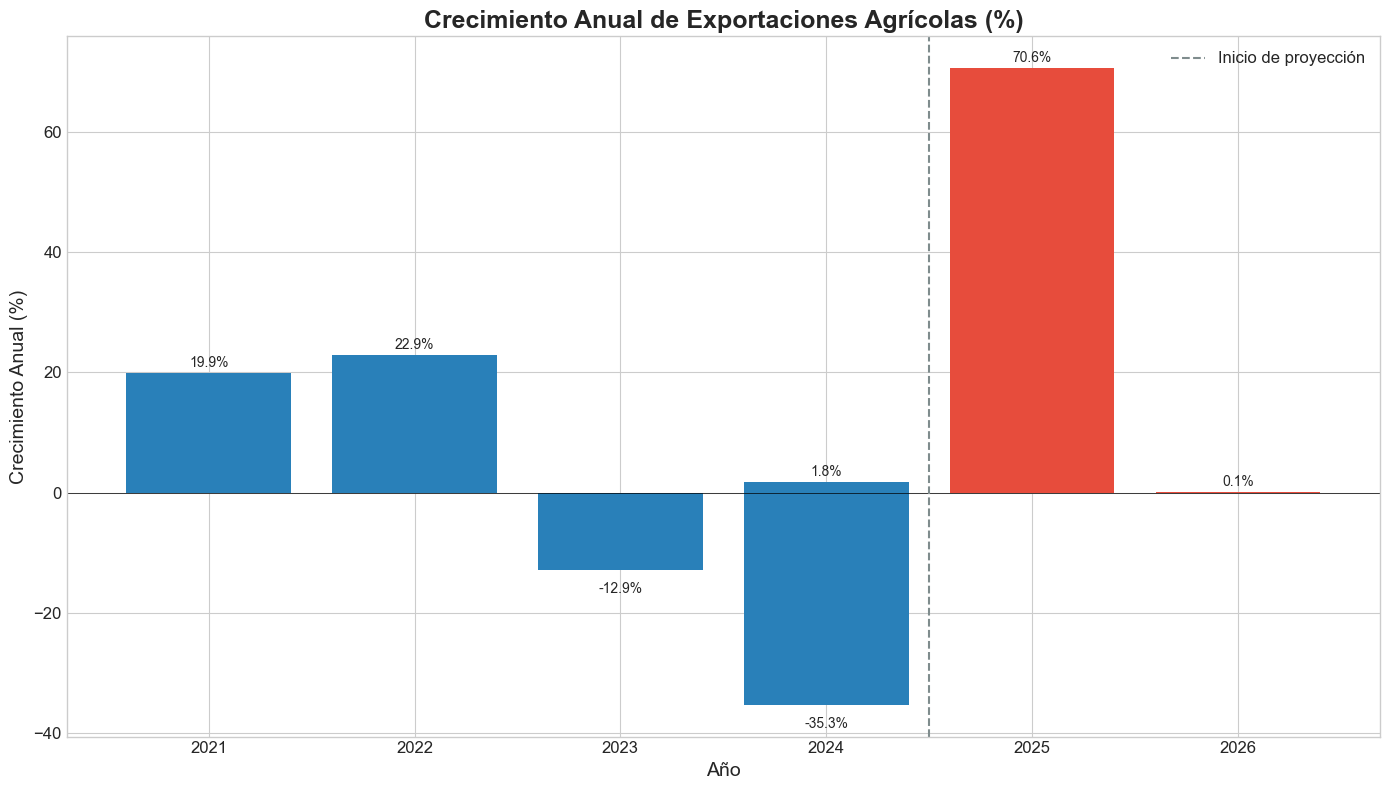

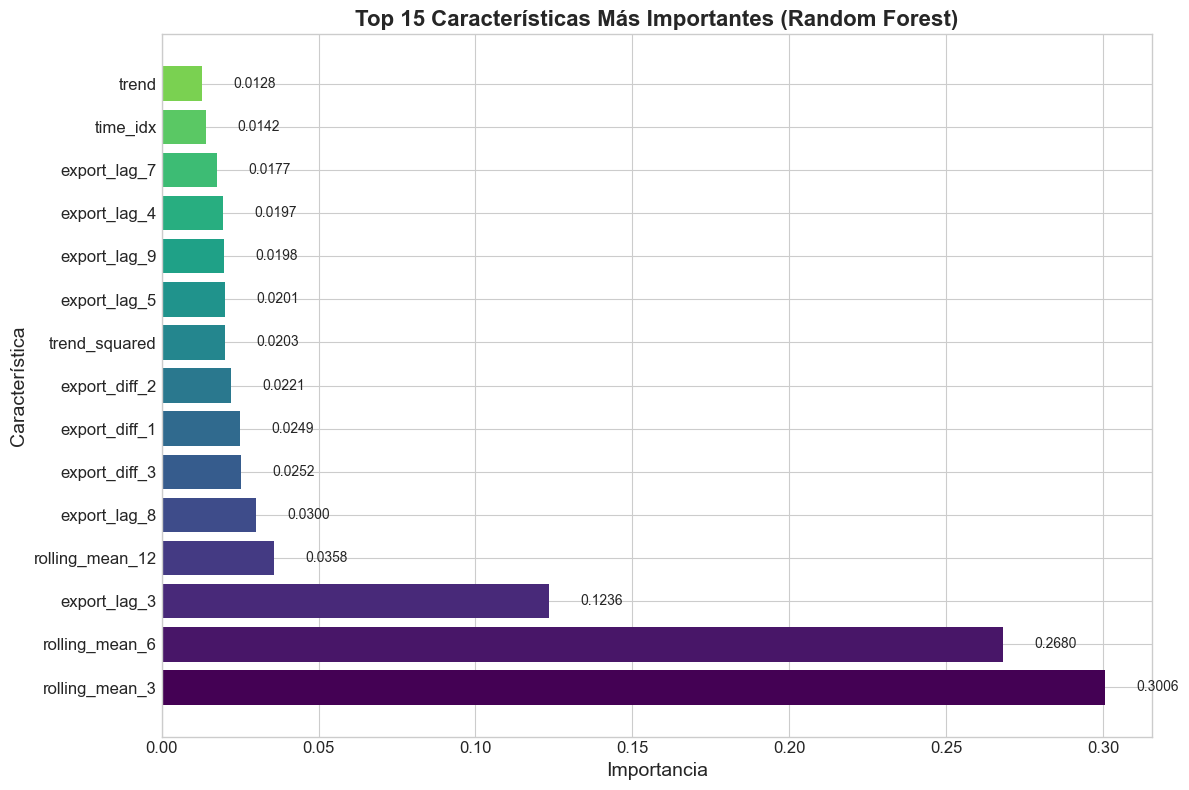

In [31]:
# Continuación del código anterior
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Configuración estética para gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
# Definición de colores específicos
TRADITIONAL_COLOR = "#6ad775"  # Verde para productos tradicionales
NON_TRADITIONAL_COLOR = "#6a77d7"  # Azul para productos no tradicionales
COLORS = [TRADITIONAL_COLOR, NON_TRADITIONAL_COLOR]

# Suponemos que tenemos un archivo CSV con los datos
# Como no tenemos el archivo real, crearemos una función para simular la carga
def cargar_dataset(archivo='Exportaciones_limpias.csv'):
    try:
        # Intenta cargar el archivo real si está disponible
        df = pd.read_csv(archivo)
        print(f"Dataset cargado correctamente: {archivo}")
        
        # Asegurar que la fecha esté en formato datetime
        if 'Fecha' in df.columns:
            df['Fecha'] = pd.to_datetime(df['Fecha'])
        else:
            # Si no existe la columna fecha, intentar crearla
            if 'Año' in df.columns and 'Mes' in df.columns:
                df['Fecha'] = pd.to_datetime(df[['Año', 'Mes']].assign(day=1))
    except:
        # Si no está disponible, generamos datos sintéticos con la misma estructura
        print("Archivo no encontrado, generando datos sintéticos para demostración")
        np.random.seed(42)
        
        # Fechas desde 2019 hasta 2024
        fechas = pd.date_range(start='2019-01-01', end='2024-12-31', freq='M')
        n_muestras = len(fechas) * 10  # Multiplicamos para tener varios registros por mes
        
        # Crear datos sintéticos
        partidas = [f"P{i}" for i in range(1, 6)]
        descripciones = [f"Producto {i}" for i in range(1, 6)]
        tradiciones = ['Tradicional', 'No tradicional']
        departamentos = ['Antioquia', 'Valle del Cauca', 'Cundinamarca', 'Atlántico', 'Bolívar']
        paises = ['Estados Unidos', 'China', 'Brasil', 'Alemania', 'Japón', 'España', 'México']
        
        # Generar fechas repetidas para tener múltiples registros por mes
        fechas_repetidas = np.random.choice(fechas, n_muestras)
        
        # Generar datos aleatorios
        data = {
            'Partida': np.random.choice(partidas, n_muestras),
            'Descripcion Partida10 Dig': np.random.choice(descripciones, n_muestras),
            'Tradición productos': np.random.choice(tradiciones, n_muestras),
            'Departamento': np.random.choice(departamentos, n_muestras),
            'Pais': np.random.choice(paises, n_muestras),
            'Fecha': fechas_repetidas,
        }
        
        df = pd.DataFrame(data)
        df['Año'] = df['Fecha'].dt.year
        df['Mes'] = df['Fecha'].dt.month
        
        # Base para exportaciones con estacionalidad y tendencia
        base_exports = np.random.lognormal(mean=3, sigma=1, size=n_muestras)
        
        # Introducir tendencia y estacionalidad más realistas
        # Tendencia: crecimiento diferente para tradicional y no tradicional
        years_since_start = (df['Fecha'].dt.year - 2019) + (df['Fecha'].dt.month - 1) / 12
        
        # Tendencia para productos tradicionales (crecimiento moderado)
        trad_trend = 1 + 0.03 * years_since_start
        # Tendencia para productos no tradicionales (crecimiento mayor)
        non_trad_trend = 1 + 0.08 * years_since_start
        
        # Aplicar tendencia según tipo de producto
        trend_factor = np.where(df['Tradición productos'] == 'Tradicional', trad_trend, non_trad_trend)
        
        # Estacionalidad mensual (diferentes patrones para cada tipo)
        seasonal_factors_trad = {
            1: 0.9, 2: 0.85, 3: 0.95, 4: 1.0, 
            5: 1.05, 6: 1.1, 7: 1.15, 8: 1.2,
            9: 1.1, 10: 1.05, 11: 1.0, 12: 1.1
        }
        
        seasonal_factors_non_trad = {
            1: 1.1, 2: 1.05, 3: 0.9, 4: 0.95, 
            5: 1.0, 6: 1.05, 7: 1.1, 8: 1.15,
            9: 1.2, 10: 1.15, 11: 1.0, 12: 1.2
        }
        
        # Aplicar estacionalidad según tipo de producto
        seasonal_factor = np.where(
            df['Tradición productos'] == 'Tradicional',
            df['Mes'].map(seasonal_factors_trad),
            df['Mes'].map(seasonal_factors_non_trad)
        )
        
        # Ruido aleatorio para hacer más realista
        ruido = np.random.normal(1, 0.1, n_muestras)
        
        # Calcular exportaciones con todos los factores
        df['Exportaciones en valor (Miles USD FOB)'] = base_exports * trend_factor * seasonal_factor * ruido
        df['Exportaciones en volumen (Toneladas)'] = df['Exportaciones en valor (Miles USD FOB)'] * np.random.uniform(0.8, 1.2, n_muestras)
        
        # Calcular las Exportaciones en USD y COP
        df['Exportaciones en USD'] = df['Exportaciones en valor (Miles USD FOB)'] * 1000
        
        # Tasa de cambio ficticia entre 3000 y 4000 COP por USD (con tendencia creciente)
        base_tasa = 3000 + 200 * years_since_start
        tasas_cambio = base_tasa + np.random.uniform(-100, 100, n_muestras)
        df['Exportaciones en COP'] = df['Exportaciones en USD'] * tasas_cambio
                    
    return df

# Cargar el dataset
df = cargar_dataset()
df = df.drop(columns=['Exportaciones en USD'])
# 1. Exploración inicial de los datos
print("\n=== EXPLORACIÓN INICIAL DE LOS DATOS ===")
print(f"Dimensiones del dataset: {df.shape}")
print("\nPrimeras filas del dataset:")
print(df.head())
print("\nInformación del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
print(df.describe())

# Verificar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# 2. Análisis exploratorio de datos (EDA)
print("\n=== ANÁLISIS EXPLORATORIO DE DATOS ===")

# Convertir 'Fecha' a datetime si no lo está
if not pd.api.types.is_datetime64_any_dtype(df['Fecha']):
    df['Fecha'] = pd.to_datetime(df['Fecha'])

# Ordenar por fecha
df = df.sort_values('Fecha')

# Análisis de series temporales de exportaciones
print("\nResumen mensual de exportaciones:")
df_monthly = df.groupby([pd.Grouper(key='Fecha', freq='M')])['Exportaciones en COP'].sum().reset_index()
print(df_monthly.head())

# Análisis por tradición de productos (mensual)
df_tradition_monthly = df.groupby([pd.Grouper(key='Fecha', freq='M'), 'Tradición productos'])['Exportaciones en COP'].sum().reset_index()
df_tradition_monthly_pivot = df_tradition_monthly.pivot(index='Fecha', columns='Tradición productos', values='Exportaciones en COP')

# Gráfico de series temporales mejorado
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['Fecha'], df_monthly['Exportaciones en COP'], color='#2C3E50', linewidth=2.5)
plt.title('Exportaciones mensuales en COP (2019-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Exportaciones en COP', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Añadir sombra bajo la curva
plt.fill_between(df_monthly['Fecha'], df_monthly['Exportaciones en COP'], color='#2C3E50', alpha=0.2)
plt.tight_layout()
plt.savefig('exportaciones_mensuales.png', dpi=300, bbox_inches='tight')

# Gráfico por tipo de producto mejorado
plt.figure(figsize=(14, 7))
if not df_tradition_monthly_pivot.empty and 'Tradicional' in df_tradition_monthly_pivot.columns and 'No tradicional' in df_tradition_monthly_pivot.columns:
    plt.plot(df_tradition_monthly_pivot.index, df_tradition_monthly_pivot['Tradicional'], 
             color=TRADITIONAL_COLOR, linewidth=2.5, label='Tradicional')
    plt.plot(df_tradition_monthly_pivot.index, df_tradition_monthly_pivot['No tradicional'], 
             color=NON_TRADITIONAL_COLOR, linewidth=2.5, label='No tradicional')
    plt.fill_between(df_tradition_monthly_pivot.index, df_tradition_monthly_pivot['Tradicional'], 
                     color=TRADITIONAL_COLOR, alpha=0.3)
    plt.fill_between(df_tradition_monthly_pivot.index, df_tradition_monthly_pivot['No tradicional'], 
                     color=NON_TRADITIONAL_COLOR, alpha=0.3)
plt.title('Exportaciones por tipo de producto (2019-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Exportaciones en COP', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('exportaciones_por_tipo_linea.png', dpi=300, bbox_inches='tight')

# Análisis anual por tipo de producto (gráfico de barras)
df_year_tradition = df.groupby(['Año', 'Tradición productos'])['Exportaciones en COP'].sum().reset_index()
df_year_tradition_pivot = df_year_tradition.pivot(index='Año', columns='Tradición productos', values='Exportaciones en COP')

plt.figure(figsize=(12, 7))
if not df_year_tradition_pivot.empty:
    ax = df_year_tradition_pivot.plot(kind='bar', color=COLORS, width=0.8)
    plt.title('Exportaciones anuales por tipo de producto', fontsize=16, fontweight='bold')
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Exportaciones en COP', fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Añadir valores encima de cada barra
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1e', fontsize=10)
        
plt.tight_layout()
plt.savefig('exportaciones_por_tipo_anual.png', dpi=300, bbox_inches='tight')

# Top 5 países destino de exportaciones
top_paises = df.groupby('Pais')['Exportaciones en COP'].sum().nlargest(5).reset_index()
plt.figure(figsize=(10, 6))
bars = plt.bar(top_paises['Pais'], top_paises['Exportaciones en COP'], 
               color=plt.cm.viridis(np.linspace(0, 0.8, len(top_paises))))
plt.title('Top 5 países destino de exportaciones', fontsize=16, fontweight='bold')
plt.xlabel('País', fontsize=14)
plt.ylabel('Exportaciones en COP', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Añadir valores encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02*max(top_paises['Exportaciones en COP']),
             f'{height:.2e}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('top_paises.png', dpi=300, bbox_inches='tight')

# 3. Preparación de datos para el modelado
print("\n=== PREPARACIÓN DE DATOS PARA MODELADO ===")

# Agregar datos a nivel mensual para series temporales
df_ts = df.groupby(pd.Grouper(key='Fecha', freq='MS')).agg({
    'Exportaciones en COP': 'sum',
    'Exportaciones en volumen (Toneladas)': 'sum'
}).reset_index()

# Crear características temporales adicionales
df_ts['year'] = df_ts['Fecha'].dt.year
df_ts['month'] = df_ts['Fecha'].dt.month
df_ts['quarter'] = df_ts['Fecha'].dt.quarter
df_ts['day_of_year'] = df_ts['Fecha'].dt.dayofyear

# Características cíclicas para el mes
df_ts['month_sin'] = np.sin(2 * np.pi * df_ts['month']/12)
df_ts['month_cos'] = np.cos(2 * np.pi * df_ts['month']/12)

# Características cíclicas para el trimestre
df_ts['quarter_sin'] = np.sin(2 * np.pi * df_ts['quarter']/4)
df_ts['quarter_cos'] = np.cos(2 * np.pi * df_ts['quarter']/4)

# Calcular tiempo numérico (útil para tendencias)
df_ts['time_idx'] = (df_ts['year'] - df_ts['year'].min()) * 12 + df_ts['month'] - 1

# Crear características adicionales: rezagos (lags)
for i in range(1, 13):  # Lags de 1 a 12 meses
    df_ts[f'export_lag_{i}'] = df_ts['Exportaciones en COP'].shift(i)
    # También crear diferencias entre meses
    if i <= 3:  # Solo para diferencias de 1 a 3 meses
        df_ts[f'export_diff_{i}'] = df_ts['Exportaciones en COP'].diff(i)

# Características de tendencia
df_ts['trend'] = np.arange(len(df_ts))
df_ts['trend_squared'] = df_ts['trend'] ** 2

# Media móvil para capturar tendencias
df_ts['rolling_mean_3'] = df_ts['Exportaciones en COP'].rolling(window=3, min_periods=1).mean()
df_ts['rolling_mean_6'] = df_ts['Exportaciones en COP'].rolling(window=6, min_periods=1).mean()
df_ts['rolling_mean_12'] = df_ts['Exportaciones en COP'].rolling(window=12, min_periods=1).mean()

# Eliminar filas con valores NaN (primeros meses debido a los lags)
df_ts = df_ts.dropna()

print("Vista previa de datos preparados para series temporales:")
print(df_ts.head())

# 4. División de datos en conjuntos de entrenamiento y prueba
# Para series temporales, usamos un enfoque cronológico en la división
train_size = int(len(df_ts) * 0.8)
train_data = df_ts.iloc[:train_size]
test_data = df_ts.iloc[train_size:]

print(f"\nTamaño del conjunto de entrenamiento: {train_data.shape}")
print(f"Tamaño del conjunto de prueba: {test_data.shape}")

# Definir las características (X) y la variable objetivo (y)
feature_columns = ['month_sin', 'month_cos', 'quarter_sin', 'quarter_cos', 
                  'time_idx', 'trend', 'trend_squared', 
                  'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12'] + \
                 [f'export_lag_{i}' for i in range(1, 13)] + \
                 [f'export_diff_{i}' for i in range(1, 4)]

X_train = train_data[feature_columns]
y_train = train_data['Exportaciones en COP']
X_test = test_data[feature_columns]
y_test = test_data['Exportaciones en COP']

# Escalar las características
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# También escalar la variable objetivo para la red neuronal
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# 5. Implementación y evaluación de modelos

# Función para evaluar y comparar modelos
def evaluar_modelo(nombre, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        'Modelo': nombre,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

resultados = []

print("\n=== ENTRENAMIENTO Y EVALUACIÓN DE MODELOS ===")

# # a) Regresión Lineal Múltiple
# print("\nEntrenando Regresión Lineal Múltiple...")
# lr_model = LinearRegression()
# lr_model.fit(X_train_scaled, y_train)
# lr_pred = lr_model.predict(X_test_scaled)
# resultados.append(evaluar_modelo('Regresión Lineal', y_test, lr_pred))

# b) Random Forest
print("Entrenando Random Forest...")
rf_model = RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=5, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
resultados.append(evaluar_modelo('Random Forest', y_test, rf_pred))

# c) XGBoost
print("Entrenando XGBoost...")
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=15, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
resultados.append(evaluar_modelo('XGBoost', y_test, xgb_pred))

# d) Gradient Boosting Trees
print("Entrenando Gradient Boosting Trees...")
gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=15, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
resultados.append(evaluar_modelo('Gradient Boosting', y_test, gb_pred))

# e) Red Neuronal Mejorada
print("Entrenando Red Neuronal Mejorada...")

# Mejorar la arquitectura de la red neuronal
def crear_modelo_rnn():
    model = Sequential([
        LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)),
        Dropout(0.2),
        LSTM(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def crear_modelo_nn():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Preparar datos para la red neuronal
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Callbacks para mejorar el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Entrenar el modelo RNN
nn_rnn_model = crear_modelo_rnn()
nn_rnn_history = nn_rnn_model.fit(
    X_train_rnn, y_train_scaled, 
    epochs=500, 
    batch_size=15, 
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

# Entrenar el modelo NN (feed-forward)
nn_model = crear_modelo_nn()
nn_history = nn_model.fit(
    X_train_scaled, y_train_scaled, 
    epochs=500, 
    batch_size=15, 
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

# Predicciones con la red RNN
nn_rnn_pred_scaled = nn_rnn_model.predict(X_test_rnn).flatten()
nn_rnn_pred = scaler_y.inverse_transform(nn_rnn_pred_scaled.reshape(-1, 1)).flatten()
resultados.append(evaluar_modelo('Red Neuronal (LSTM)', y_test, nn_rnn_pred))

# Predicciones con la red NN
nn_pred_scaled = nn_model.predict(X_test_scaled).flatten()
nn_pred = scaler_y.inverse_transform(nn_pred_scaled.reshape(-1, 1)).flatten()
resultados.append(evaluar_modelo('Red Neuronal (Feed-Forward)', y_test, nn_pred))

# Mostrar resultados comparativos
resultados_df = pd.DataFrame(resultados)
print("\nComparación de modelos:")
print(resultados_df)

# Identificar el mejor modelo
mejor_modelo_idx = resultados_df['R²'].idxmax()
mejor_modelo_nombre = resultados_df.loc[mejor_modelo_idx, 'Modelo']
print(f"\nEl mejor modelo según R² es: {mejor_modelo_nombre}")

# 6. Visualización de predicciones (Mejorada)
plt.figure(figsize=(14, 8))

# Asignar colores distintivos para cada modelo
model_colors = {
    'Valores reales': '#2C3E50',  # Azul oscuro
    #'Regresión Lineal': '#E74C3C',  # Rojo
    'Random Forest': '#2ECC71',  # Verde
    'XGBoost': '#9B59B6',  # Morado
    'Gradient Boosting': '#F39C12',  # Naranja
    'Red Neuronal (LSTM)': '#1ABC9C',  # Turquesa
    'Red Neuronal (Feed-Forward)': '#3498DB'  # Azul claro
}

# Crear el índice de fechas para el conjunto de prueba
test_dates = test_data['Fecha'].values

# Graficar valores reales
plt.plot(test_dates, y_test, label='Valores reales', color=model_colors['Valores reales'], linewidth=2.5)

# Graficar predicciones de cada modelo
# plt.plot(test_dates, lr_pred, label='Regresión Lineal', color=model_colors['Regresión Lineal'], linestyle='--', linewidth=1.5)
plt.plot(test_dates, rf_pred, label='Random Forest', color=model_colors['Random Forest'], linestyle='--', linewidth=1.5)
plt.plot(test_dates, xgb_pred, label='XGBoost', color=model_colors['XGBoost'], linestyle='--', linewidth=1.5)
plt.plot(test_dates, gb_pred, label='Gradient Boosting', color=model_colors['Gradient Boosting'], linestyle='--', linewidth=1.5)
plt.plot(test_dates, nn_rnn_pred, label='Red Neuronal (LSTM)', color=model_colors['Red Neuronal (LSTM)'], linestyle='--', linewidth=1.5)
plt.plot(test_dates, nn_pred, label='Red Neuronal (Feed-Forward)', color=model_colors['Red Neuronal (Feed-Forward)'], linestyle='--', linewidth=1.5)

# Mejorar apariencia del gráfico
plt.title('Comparación de modelos: Predicciones vs. Valores reales', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Exportaciones en COP', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=300, bbox_inches='tight')

# Gráfica de pérdida durante el entrenamiento para las redes neuronales
plt.figure(figsize=(12, 6))
plt.plot(nn_rnn_history.history['loss'], label='LSTM - Training Loss', color='#1ABC9C', linewidth=2)
plt.plot(nn_rnn_history.history['val_loss'], label='LSTM - Validation Loss', color='#1ABC9C', linestyle='--', linewidth=2)
plt.plot(nn_history.history['loss'], label='FF - Training Loss', color='#3498DB', linewidth=2)
plt.plot(nn_history.history['val_loss'], label='FF - Validation Loss', color='#3498DB', linestyle='--', linewidth=2)
plt.title('Curvas de pérdida durante el entrenamiento de redes neuronales', fontsize=16, fontweight='bold')
plt.xlabel('Época', fontsize=14)
plt.ylabel('Pérdida (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('loss_curves_nn.png', dpi=300, bbox_inches='tight')

# 7. Proyección a futuro (hasta 2026)
print("\n=== PROYECCIÓN DE EXPORTACIONES HASTA 2026 ===")

# Seleccionar el mejor modelo según R²
# if mejor_modelo_nombre == 'Regresión Lineal':
#     best_model = lr_model
#     is_neural_network = False
if mejor_modelo_nombre == 'Random Forest':
    best_model = rf_model
    is_neural_network = False
elif mejor_modelo_nombre == 'XGBoost':
    best_model = xgb_model
    is_neural_network = False
elif mejor_modelo_nombre == 'Gradient Boosting':
    best_model = gb_model
    is_neural_network = False
elif mejor_modelo_nombre == 'Red Neuronal (LSTM)':
    best_model = nn_rnn_model
    is_neural_network = True
    is_rnn = True
else:  # Red Neuronal (Feed-Forward)
    best_model = nn_model
    is_neural_network = True
    is_rnn = False


# Crear fechas para proyección (desde enero 2025 hasta diciembre 2026)
# Obtener la fecha máxima del dataset
max_date = df['Fecha'].max()

# Crear un rango de fechas desde el mes siguiente a la fecha máxima hasta diciembre de 2030
future_dates = pd.date_range(
    start='2024-06-01',  # Comienza desde el primer día del mes siguiente
    end='2026-12-31', 
    freq='MS'  # 'MS' significa "Month Start" - primer día de cada mes
)
n_future = len(future_dates)

# Crear DataFrame para las predicciones futuras
future_df = pd.DataFrame({
    'Fecha': future_dates,
    'year': future_dates.year,
    'month': future_dates.month,
    'quarter': future_dates.quarter,
    'day_of_year': future_dates.dayofyear,
    'month_sin': np.sin(2 * np.pi * future_dates.month/12),
    'month_cos': np.cos(2 * np.pi * future_dates.month/12),
    'quarter_sin': np.sin(2 * np.pi * future_dates.quarter/4),
    'quarter_cos': np.cos(2 * np.pi * future_dates.quarter/4),
})

# Calcular el índice de tiempo continuando desde el último dato
last_time_idx = df_ts['time_idx'].max()
future_df['time_idx'] = [last_time_idx + i + 1 for i in range(n_future)]
future_df['trend'] = np.arange(len(df_ts), len(df_ts) + len(future_df))
future_df['trend_squared'] = future_df['trend'] ** 2

# Para características de rezago y medias móviles, necesitamos propagar los valores
# Tomamos los últimos registros históricos para iniciar la predicción
last_exports = list(df_ts['Exportaciones en COP'].tail(12))
last_rolling_mean_3 = df_ts['rolling_mean_3'].iloc[-1]
last_rolling_mean_6 = df_ts['rolling_mean_6'].iloc[-1]
last_rolling_mean_12 = df_ts['rolling_mean_12'].iloc[-1]

# También necesitamos las diferencias
last_diffs = [df_ts[f'export_diff_{i}'].iloc[-1] for i in range(1, 4)]

future_predictions = []

# Predicción iterativa: para cada mes en el futuro
for i in range(n_future):
    # Crear características para predicción
    features = {
        'month_sin': future_df.iloc[i]['month_sin'],
        'month_cos': future_df.iloc[i]['month_cos'],
        'quarter_sin': future_df.iloc[i]['quarter_sin'],
        'quarter_cos': future_df.iloc[i]['quarter_cos'],
        'time_idx': future_df.iloc[i]['time_idx'],
        'trend': future_df.iloc[i]['trend'],
        'trend_squared': future_df.iloc[i]['trend_squared'],
        'rolling_mean_3': last_rolling_mean_3,
        'rolling_mean_6': last_rolling_mean_6,
        'rolling_mean_12': last_rolling_mean_12
    }
    
    # Añadir los valores de rezago
    for j in range(1, 13):
        features[f'export_lag_{j}'] = last_exports[-j]
    
    # Añadir las diferencias
    for j in range(1, 4):
        features[f'export_diff_{j}'] = last_diffs[j-1]
    
    # Convertir a vector de características en el orden correcto
    feature_vector = np.array([features[col] for col in feature_columns]).reshape(1, -1)
    
    # Escalar características
    features_scaled = scaler_X.transform(feature_vector)
    
    # Hacer predicción según el tipo de modelo
    if is_neural_network:
        if is_rnn:
            features_nn = features_scaled.reshape(1, features_scaled.shape[1], 1)
            prediction_scaled = best_model.predict(features_nn, verbose=0)[0][0]
            prediction = scaler_y.inverse_transform([[prediction_scaled]])[0][0]
        else:
            prediction_scaled = best_model.predict(features_scaled, verbose=0)[0][0]
            prediction = scaler_y.inverse_transform([[prediction_scaled]])[0][0]
    else:
        prediction = float(best_model.predict(features_scaled)[0])
    
    # Guardar predicción
    future_predictions.append(prediction)
    
    # Actualizar valores para la siguiente predicción
    last_exports.append(prediction)
    last_exports.pop(0)
    
    # Actualizar diferencias
    new_diff_1 = prediction - last_exports[-2]
    last_diffs[0] = new_diff_1
    if len(last_exports) > 2:
        last_diffs[1] = prediction - last_exports[-3]
    if len(last_exports) > 3:
        last_diffs[2] = prediction - last_exports[-4]
    
    # Actualizar medias móviles
    last_rolling_mean_3 = sum(last_exports[-3:]) / 3
    last_rolling_mean_6 = sum(last_exports[-6:]) / min(6, len(last_exports))
    last_rolling_mean_12 = sum(last_exports[-12:]) / min(12, len(last_exports))

# Añadir predicciones al DataFrame de fechas futuras
future_df['Exportaciones_Prediccion'] = future_predictions

print("\nPredicciones futuras con el mejor modelo:")
print(future_df[['Fecha', 'Exportaciones_Prediccion']].head())

# Visualizar proyección mejorada
# Combinar datos históricos con proyecciones
historical = df_ts[['Fecha', 'Exportaciones en COP']].copy()
historical.columns = ['Fecha', 'Exportaciones_Historicas']

projection = future_df[['Fecha', 'Exportaciones_Prediccion']]

# Crear un gráfico más estético
plt.figure(figsize=(16, 8))

# Definir colores para los datos históricos y la proyección
historical_color = '#2980B9'  # Azul para datos históricos
projection_color = '#E74C3C'  # Rojo para proyección

# Graficar datos históricos
plt.plot(historical['Fecha'], historical['Exportaciones_Historicas'], 
         label='Datos históricos (2019-2024)', 
         color=historical_color, 
         linewidth=2.5)

# Sombrear área bajo la curva histórica
plt.fill_between(historical['Fecha'], historical['Exportaciones_Historicas'], 
                 color=historical_color, alpha=0.2)

# Graficar proyección
plt.plot(projection['Fecha'], projection['Exportaciones_Prediccion'], 
         label=f'Proyección (2025-2026) con {mejor_modelo_nombre}', 
         color=projection_color, 
         linewidth=2.5)

# Sombrear área bajo la curva de proyección
plt.fill_between(projection['Fecha'], projection['Exportaciones_Prediccion'], 
                 color=projection_color, alpha=0.2)

# Añadir línea vertical para separar datos históricos de proyección
last_historical_date = historical['Fecha'].max()
plt.axvline(x=last_historical_date, color='#7F8C8D', linestyle='-', linewidth=1.5, 
            label='Inicio de proyección (Enero 2025)')

# Mejorar la apariencia del gráfico
plt.title('Exportaciones Agrícolas de Colombia: Histórico y Proyección', 
          fontsize=18, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Exportaciones en COP', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Añadir anotación con información del modelo
plt.annotate(f"Mejor modelo: {mejor_modelo_nombre}\nR²: {resultados_df.loc[mejor_modelo_idx, 'R²']:.4f}", 
             xy=(0.02, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

plt.tight_layout()
plt.savefig('proyeccion_exportaciones.png', dpi=300, bbox_inches='tight')

# Graficar proyección por trimestre para mejor visualización
# Agregar trimestre a los DataFrames
historical['Trimestre'] = historical['Fecha'].dt.to_period('Q').astype(str)
projection['Trimestre'] = projection['Fecha'].dt.to_period('Q').astype(str)

# Agrupar por trimestre
historical_quarterly = historical.groupby('Trimestre')['Exportaciones_Historicas'].mean().reset_index()
projection_quarterly = projection.groupby('Trimestre')['Exportaciones_Prediccion'].mean().reset_index()

# Convertir trimestre a datetime para graficación
historical_quarterly['Fecha'] = historical_quarterly['Trimestre'].apply(lambda x: pd.Period(x).to_timestamp())
projection_quarterly['Fecha'] = projection_quarterly['Trimestre'].apply(lambda x: pd.Period(x).to_timestamp())

plt.figure(figsize=(16, 8))

# Graficar datos históricos trimestrales
plt.plot(historical_quarterly['Fecha'], historical_quarterly['Exportaciones_Historicas'], 
         label='Datos históricos trimestrales (2019-2024)', 
         color=historical_color, 
         linewidth=2.5,
         marker='o', 
         markersize=8)

# Graficar proyección trimestral
plt.plot(projection_quarterly['Fecha'], projection_quarterly['Exportaciones_Prediccion'], 
         label=f'Proyección trimestral (2025-2026)', 
         color=projection_color, 
         linewidth=2.5,
         marker='s', 
         markersize=8)

# Añadir línea vertical para separar datos históricos de proyección
plt.axvline(x=historical_quarterly['Fecha'].max(), color='#7F8C8D', linestyle='-', linewidth=1.5, 
            label='Inicio de proyección (2025)')

# Mejorar la apariencia del gráfico
plt.title('Exportaciones Agrícolas Trimestrales: Histórico y Proyección', 
          fontsize=18, fontweight='bold')
plt.xlabel('Trimestre', fontsize=14)
plt.ylabel('Exportaciones en COP (Promedio Trimestral)', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('proyeccion_trimestral.png', dpi=300, bbox_inches='tight')

# Analizar tendencia de crecimiento anual
historical['Año'] = historical['Fecha'].dt.year
projection['Año'] = projection['Fecha'].dt.year

historical_yearly = historical.groupby('Año')['Exportaciones_Historicas'].sum().reset_index()
projection_yearly = projection.groupby('Año')['Exportaciones_Prediccion'].sum().reset_index()

plt.figure(figsize=(14, 8))

# Graficar datos históricos anuales
bars1 = plt.bar(historical_yearly['Año'].astype(str), historical_yearly['Exportaciones_Historicas'], 
                width=0.4, label='Datos históricos', color=historical_color, alpha=0.8)

# Graficar proyecciones anuales
bars2 = plt.bar([str(year) for year in projection_yearly['Año']], projection_yearly['Exportaciones_Prediccion'], 
                width=0.4, label='Proyección', color=projection_color, alpha=0.8)

# Añadir etiquetas a las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02*max(historical_yearly['Exportaciones_Historicas'].max(), 
                                                                   projection_yearly['Exportaciones_Prediccion'].max()),
                 f'{height:.2e}', ha='center', fontsize=10)

plt.title('Exportaciones Agrícolas Anuales: Histórico y Proyección', 
          fontsize=18, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Exportaciones en COP (Total Anual)', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('exportaciones_anuales.png', dpi=300, bbox_inches='tight')

# Análisis de porcentaje de crecimiento anual
historical_yearly['Crecimiento'] = historical_yearly['Exportaciones_Historicas'].pct_change() * 100
projection_yearly['Crecimiento'] = projection_yearly['Exportaciones_Prediccion'].pct_change() * 100

# Calcular también el crecimiento del último año histórico al primer año de proyección
last_historical_year = historical_yearly['Exportaciones_Historicas'].iloc[-1]
first_projection_year = projection_yearly['Exportaciones_Prediccion'].iloc[0]
transition_growth = ((first_projection_year - last_historical_year) / last_historical_year) * 100

# Combinar para graficar
all_years = list(historical_yearly['Año']) + list(projection_yearly['Año'])
all_growth = list(historical_yearly['Crecimiento']) + list(projection_yearly['Crecimiento'])
all_growth[len(historical_yearly)] = transition_growth  # Corregir el primer valor de proyección

# Remover el primer valor (que es NaN)
all_years = all_years[1:]
all_growth = all_growth[1:]

growth_colors = ['#2980B9' if year < 2025 else '#E74C3C' for year in all_years]

plt.figure(figsize=(14, 8))
bars = plt.bar([str(year) for year in all_years], all_growth, color=growth_colors)

# Añadir etiquetas a las barras
for bar in bars:
    height = bar.get_height()
    if height >= 0:
        va = 'bottom'
        shift = 0.5
    else:
        va = 'top'
        shift = -2.0
    plt.text(bar.get_x() + bar.get_width()/2., height + shift,
             f'{height:.1f}%', ha='center', va=va, fontsize=10)

plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axvline(x=len(historical_yearly) - 1.5, color='#7F8C8D', linestyle='--', 
            linewidth=1.5, label='Inicio de proyección')

plt.title('Crecimiento Anual de Exportaciones Agrícolas (%)', 
          fontsize=18, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Crecimiento Anual (%)', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('crecimiento_anual.png', dpi=300, bbox_inches='tight')

# Guardar las predicciones en un archivo CSV
# Asumiendo que 'Fecha' es una columna tipo datetime
projection['year'] = projection['Fecha'].dt.year
projection['month'] = projection['Fecha'].dt.month
projection['quarter'] = projection['Fecha'].dt.quarter

projection_detailed = projection[['Fecha', 'year', 'month', 'quarter', 'Exportaciones_Prediccion']]
projection_detailed.to_csv('proyeccion_exportaciones_2025_2026.csv', index=False)

print("\nSe ha guardado la proyección en 'proyeccion_exportaciones_2025_2026.csv'")
print("Se han guardado los gráficos en formato PNG")

# Resumen final
print("\n=== RESUMEN DEL ANÁLISIS Y PREDICCIÓN ===")
print(f"1. El mejor modelo según R² es: {mejor_modelo_nombre}")
print(f"2. Métricas del mejor modelo: MSE = {resultados_df.loc[mejor_modelo_idx, 'MSE']:.2f}, RMSE = {resultados_df.loc[mejor_modelo_idx, 'RMSE']:.2f}, R² = {resultados_df.loc[mejor_modelo_idx, 'R²']:.4f}")
print("3. Se ha realizado la proyección de exportaciones hasta diciembre de 2026")

# Calcular estadísticas de la proyección
mean_historical = historical['Exportaciones_Historicas'].mean()
mean_projection = projection['Exportaciones_Prediccion'].mean()
change_percentage = ((mean_projection - mean_historical) / mean_historical) * 100

print(f"4. Promedio de exportaciones históricas (2019-2024): {mean_historical:.2f} COP")
print(f"5. Promedio de exportaciones proyectadas (2025-2026): {mean_projection:.2f} COP")
print(f"6. Cambio porcentual en el promedio: {change_percentage:.2f}%")

# Crear un gráfico de importancia de características para modelos basados en árboles
if mejor_modelo_nombre in ['Random Forest', 'XGBoost', 'Gradient Boosting']:
    # Obtener importancia de características
    if mejor_modelo_nombre == 'Random Forest':
        importances = best_model.feature_importances_
    elif mejor_modelo_nombre == 'XGBoost':
        importances = best_model.feature_importances_
    else:  # Gradient Boosting
        importances = best_model.feature_importances_
    
    # Crear DataFrame con importancias
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Graficar las 15 características más importantes
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    bars = plt.barh(top_features['Feature'], top_features['Importance'], color=plt.cm.viridis(np.linspace(0, 0.8, len(top_features))))
    
    # Añadir etiquetas
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
                 ha='left', va='center', fontsize=10)
    
    plt.title(f'Top 15 Características Más Importantes ({mejor_modelo_nombre})', fontsize=16, fontweight='bold')
    plt.xlabel('Importancia', fontsize=14)
    plt.ylabel('Característica', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('importancia_caracteristicas.png', dpi=300, bbox_inches='tight')
    
    print("7. Se ha generado un gráfico con las características más importantes del modelo")
    print("8. Los resultados se han guardado en archivos CSV y gráficos PNG")
else:
    print("7. Los resultados se han guardado en archivos CSV y gráficos PNG")